# Import

In [1]:
%pylab --no-import-all notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
import qutip as qp
from importlib import reload
import scipy

# Global parameters

In [3]:
plt.rcParams['text.usetex'] = False  # True - for pretty graphs

# Units convention
Energy unit = $10^{-9} \frac{\text{EnergySI}}{h}$ GHz $\newline$
time = $10^{-9}$timeSI - [ns]

# Single transmon

In [4]:
import transmon_simulations_lib.single_transmon.transmon
reload(transmon_simulations_lib.single_transmon.transmon)
from transmon_simulations_lib.single_transmon.transmon import Transmon

import transmon_simulations_lib.single_transmon.tmon_eigensystem
reload(transmon_simulations_lib.single_transmon.tmon_eigensystem)
from transmon_simulations_lib.single_transmon.tmon_eigensystem import TmonPars

from transmon_simulations_lib.custom_ops import raising_op, lowering_op

Transmon.py module: cpu number detected 4
Transmon.py module: cpu number detected 4


## Tmon & num parameters

In [5]:
Ec=0.6
Ej=28
alpha=0.2
gamma_rel = 10e-6
gamma_phi = 20e-6

Nc = 10
dims = 2*Nc + 1

## Eigenvectors projection on self. Case I: without potential shift from flux

__**Case I**__ <br>
*Used in current code*
$$ \phi_{ext} = 2 \pi \frac{\Phi_{ext}}{\Phi_0} $$
where $\Phi_0 = h/2e $ - flux quantum in SI
$$ H = E_C n^2 - E_J sign\left( cos{\left( \frac{\phi_{ext}}{2}\right)} \right)
\sqrt{1 + \alpha^2 + 2 \alpha \cos{\left( \frac{\phi_{ext}}{2} \right)}} \cos{\phi} $$
where 
$$\phi = \frac{\phi_1 + \phi_2}{2} $$
$\phi_i$ - phase drop accross i-th JJ
where $\phi$ - is qubit branch flux canonical variable<br>
$\alpha = E_{J1}/E_{J2} < 1$ is the ratio between smaller JJ energy to larger.

  0%|          | 0/101 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


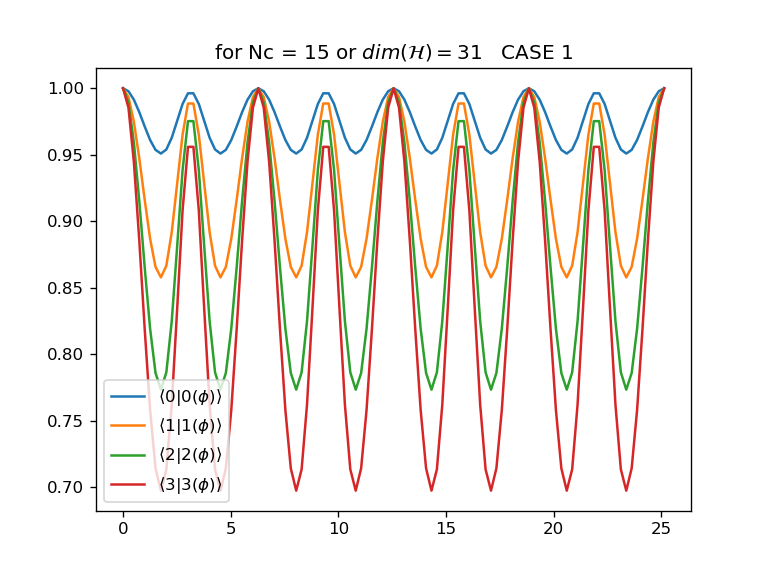

Text(0.5, 1.0, 'for Nc = 15 or $dim(\\mathcal{H}) = 31 $   CASE 1')

In [6]:
phi_Ext_list = np.linspace(0, 8*np.pi, 101)
pars_list = [TmonPars(Ec, Ej, alpha, phi, 0, gamma_rel, gamma_phi) for phi in phi_Ext_list]
tr1 = Transmon(pars_list, Nc=Nc, res_trunc=4)
sols1 = tr1.solve()
res_list1 = np.array([sol.evecs_arr for sol in sols1])
n_entries = len(res_list1)
fig, ax = plt.subplots(1,1)
goodness1 = np.zeros(res_list1.shape, dtype=complex)

for i in range(res_list1.shape[0]):
    for j in range(res_list1.shape[1]):
        goodness1[i,j] = np.abs((res_list1[i,j].dag() * res_list1[0,j])[0,0])

for vec_idx, vec_goodness in enumerate(goodness1.T):
    ax.plot(phi_Ext_list, np.abs(vec_goodness), label=r"$\left\langle %d | %d(\phi) \right\rangle  $"%(vec_idx,vec_idx))
ax.legend()
ax.set_title(r"for Nc = 15 or $dim(\mathcal{H}) = 31 $   CASE 1")

## Eigenvectors projection on self. Case II: potential well shifts from flux

__**Case II**__
*utilizing static quantization of transmon by Koch et.al https://doi.org/10.1103/PhysRevA.76.042319*
$$ H = E_C n^2 - E_J sgn({cos{\left( \frac{\phi_{ext}}{2} \right)}}) \sqrt{1 + \alpha^2 + 2 \alpha \cos{\left( \frac{\phi_{ext}}{2} \right)}} \cos{\left( \phi - \phi_0 \right) } $$
where $\phi_0 = \arctan{\left( d \tan{\left( \frac{\phi_{ext}}{2} \right)} \right)} $ and $d = \frac{1-\alpha}{1+\alpha}$ <br> 

  0%|          | 0/101 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


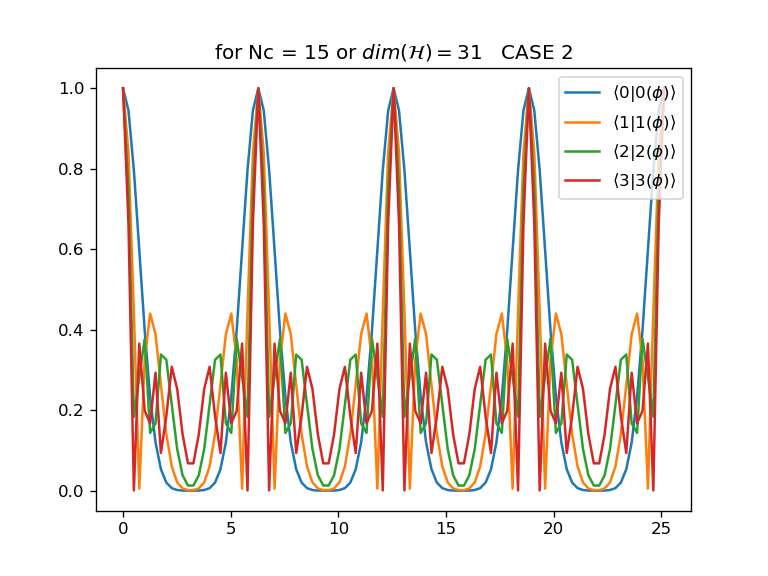

Text(0.5, 1.0, 'for Nc = 15 or $dim(\\mathcal{H}) = 31 $   CASE 2')

In [7]:
pars_list = [TmonPars(Ec, Ej, alpha, 0, phi, gamma_rel, gamma_phi) for phi in phi_Ext_list]
tr2 = Transmon(pars_list, Nc=Nc, res_trunc=4)
sols2 = tr2.solve()
res_list2 = np.array([sol.evecs_arr for sol in sols2])
n_entries = len(res_list2)
fig, ax = plt.subplots(1,1)
goodness2 = np.zeros(res_list2.shape, dtype=complex)

for i in range(res_list2.shape[0]):
    for j in range(res_list2.shape[1]):
        goodness2[i,j] = np.abs((res_list2[i,j].dag() * res_list2[0,j])[0,0])

for vec_idx, vec_goodness in enumerate(goodness2.T):
    ax.plot(phi_Ext_list, np.abs(vec_goodness), label=r"$\left\langle %d | %d(\phi) \right\rangle  $"%(vec_idx,vec_idx))
ax.legend()
ax.set_title(r"for Nc = 15 or $dim(\mathcal{H}) = 31 $   CASE 2")

## Case I and Case II E01 energy comparison

<IPython.core.display.Javascript object>


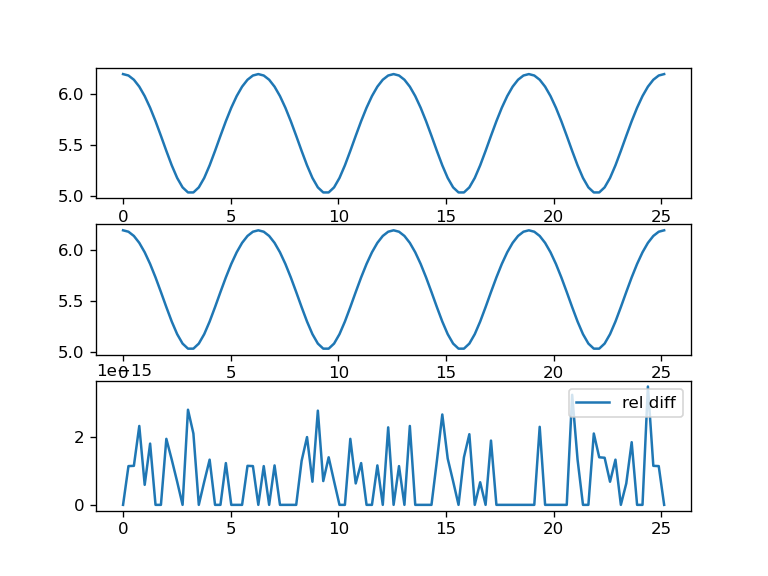

In [8]:
# plt.rcParams['text.usetex'] = True
E01_1 = np.array([sol.E01() for sol in sols1])
E01_2 = np.array([sol.E01() for sol in sols2])
fig, axs = plt.subplots(3,1)
axs[0].plot(phi_Ext_list, E01_1)
axs[1].plot(phi_Ext_list, E01_2)
axs[2].plot(phi_Ext_list, np.abs(E01_1 - E01_2)/E01_1, label="rel diff")
axs[2].legend() 

## Eigenvectors projection on self. Case III: intermediate, irrotational gauge.

**Case III**
*utilizing You, X.,et.al (Koch included) (2019). https://doi.org/10.1103/PhysRevB.99.174512*

Written in branch variables *branch* fluxes (G. Burkard et. al 2004 https://journals.aps.org/prb/abstract/10.1103/PhysRevB.69.064503) instead of *node* fluxes (Devoret). Each branch is oriented and each loop is oriented as well. Their relative orientation is captured by *mesh matrix* $\mathbf{R}$:
$$ \left( \mathbf{R} \right)_{i,j} = \cases{
1  \;\;\;\; \Phi_j \in L_i, \text{cooriented branch and loop}\\
-1 \;\;\; \Phi_j \in L_i, \text{contraoriented branch and loop}\\
0 \;\;\;\; \Phi_j \notin L_i, \text{loop does include branch}\\
} $$

R matrix connects branch fluxes and loops fluxes as follows:

$$ \mathbf{\Phi_e}(t)_i = \left(\mathbf{R}\right)_{i,j} \; \mathbf{\Phi}(t)_j $$
where $ \mathbf{\Phi_e}(t)_i  $ - flux through i-th loop (i goes from 1 to F - mesh number of a circuit).<br>
Mesh - set of loops where each loop does not contain other loop<br>
and $\mathbf{\Phi}(t)_j$ - branch flux of j-th branch

Due to the fact that we have F contraints for branch fluxes generated by $\mathbf{R}$ above we will declare new (N-F) flux variables  $\tilde{\mathbf{\Phi}}$:
$$ \tilde{\mathbf{\Phi}} = \mathbf{M} \mathbf{\Phi} $$
where $\mathbf{M}$ - is (N-F)xN matrix that is to be found to eliminate $\dot{\Phi}_e(t)_i$ resulting Hamiltonian.

Declaring new vector
$$\tilde{\mathbf{\Phi}}_{+} = \left( 
\matrix{
\tilde{\mathbf{\Phi}} \\
\mathbf{\Phi}_e
}
\right)
$$

and the new matrix
$$\mathbf{M}_{+} = \left( 
\matrix{
\mathbf{M} \\
\mathbf{R}
}
\right)
$$

we can write down both degrees of freedom and constraints as a single equation:

$$\tilde{\mathbf{\Phi}}_{+} = \mathbf{M}_{+} \mathbf{\Phi} $$

kinetic energy in branch represention (N branches):
$$ \mathcal{L}_k = \frac{1}{2}\dot{\mathbf{\Phi}}^T \mathbf{C} \dot{\mathbf{\Phi}} $$
where $ \mathbf{C} = diag\left(C_1, C_2, ..., C_N\right) $ matrix of branches capacitances.

Moving towards canonical variables and external fluxes:
$$\dot{\mathbf{\Phi}} = \mathbf{M}_{+}^{-1} \dot{\tilde{\mathbf{\Phi}}}_{+} $$
<br>
$$ \mathcal{L}_{\text{K}} = \frac{1}{2}\dot{\tilde{\mathbf{\Phi}}}_{+}^T \mathbf{C}_{\text{eff}} \dot{\tilde{\mathbf{\Phi}}}_{+} $$
where 
$$\mathbf{C}_{\text{eff}} = (\mathbf{M}_{+}^{-1})^T \mathbf{C} \left(\mathbf{M}_{+}^{-1}\right) $$

Since we wish to decouple $\dot{\tilde{\mathbf{\Phi}}}$ and $\dot{\mathbf{\Phi}}_e$
than $\mathbf{C}_{\text{eff}}$ has to be block-diagonal with blocks (N-F)x(N-F) and FxF.
Former corresponding to kinetic energy based on new canonical variables $\dot{\tilde{\mathbf{\Phi}}}$ and the latter will be excluded from Lagrangian as a total derivative of time only dependent function.<br>
Block-diagonal requirement is also applies to the inverse of $\mathbf{C}_{\text{eff}}$:

$$ \mathbf{C}_{\text{eff}}^{-1} =  (\mathbf{M}_{+}) \mathbf{C}^{-1} \left(\mathbf{M}_{+} \right)^T = \left( 
\matrix{
\mathbf{M} \\
\mathbf{R}
}
\right)
\mathbf{C}^{-1}
\left(
\matrix{
\mathbf{M}^T & \mathbf{R}^T
}
\right) = 
\left(
\matrix{
\mathbf{M}\mathbf{C}^{-1}\mathbf{M} & \mathbf{M}\mathbf{C}^{-1}\mathbf{R}^T \\
\mathbf{R}\mathbf{C}^{-1}\mathbf{M} & \mathbf{R}\mathbf{C}^{-1}\mathbf{R}
}
\right)
$$

Hence we have to find atleast one matrix that satisfy:
$$\mathbf{R}\mathbf{C}^{-1}\mathbf{M}^T = 0$$

Speaking in terms of linear argebra: rows of $\mathbf{M}$ is the null space of $\mathbf{R}\mathbf{C}^{-1}$ operator.

Consider the following schematics where leftmost JJ is substituted with simple capacitor C

![title](Case_3.png)

$$\mathbf{R} = 
\left(
\matrix{
1 & -1 & 0 \\
0 & 1 & -1
}
\right)
$$
$$\mathbf{C}^{-1} = diag\left( C_1^{-1},C_2^{-1},C_{3}^{-1} \right)$$
$$ \mathbf{R} \mathbf{C}^{-1} = 
\left(
\matrix{
C_1^{-1} & -C_2^{-1} & 0 \\
0 & C_2^{-1} & -C_3^{-1}
}
\right)
$$
<br>
from here we can deduce that (properly normalized by $C_{\Sigma} = \Sigma C_i$:
$$ M = \frac{1}{C_{\Sigma}}
\left(
\matrix{C_1 & C_2 & C_3 } 
\right) $$
<br>
is the solution that satisfies
$$\mathbf{R}\mathbf{C}^{-1}\mathbf{M}^T = 0$$

Finally we have only one "free" branch variable: <br>
$ \tilde{\phi} = \mathbf{M} \mathbf{\Phi} = \sum_{j=1}^{N_{br}=3} \frac{C_j}{C_{\Sigma}}\Phi_j$

<br>
Finding equation for $\mathbf{C}_{\text{eff}}$:

$$ \mathbf{M}_{+} = 
\left(
\matrix{
\mathbf{M} \\
\mathbf{R}
}
\right) =
\left(
\matrix{
\frac{C_1}{C_{\Sigma}} & \frac{C_2}{C_{\Sigma}} & \frac{C_3}{C_{\Sigma}}\\
1 & -1 & 0 \\
0 & 1 & -1
}
\right)
$$

$$ (\mathbf{M}_{+})^{-1} = 
\left(
\matrix{
1 & \frac{C_2 + C_3}{C_{\Sigma}} & \frac{C_3}{C_{\Sigma}} \\
1 & -\frac{C_1}{C_{\Sigma}} & \frac{C_3}{C_{\Sigma}} \\
1 & -\frac{C_1}{C_{\Sigma}} & -\frac{C_1 + C_2}{C_{\Sigma}}
}
\right) $$

<br>
And finally
$$\mathbf{C}_{\text{eff}} = 
\left(
\matrix{
C_{\Sigma} & 0 & 0 \\
0 & \frac{C_1(C_2 + C_3)}{C_{\Sigma}} & \frac{C_1 C_3}{C_{\Sigma}} \\
0 & \frac{C_1 C_3}{C_{\Sigma}} &\frac{(С_1+С_2)C_3}{C_{\Sigma}}
}
\right)
$$

$$\mathbf{\Phi} = \mathbf{M}_{+}^{-1} \tilde{\mathbf{\Phi}}_{+} $$
or

$$ \left(
\matrix{ 
\Phi_1 \\
\Phi_2 \\
\Phi_3
}
\right) = 
(\mathbf{M}_{+})^{-1} 
\left(\matrix{ 
\tilde{\phi} \\
\Phi_e^1 \\
\Phi_e^2
}
\right) $$

Total Hamiltonian in this case will be

$$ H =  E_C n^2 - 
E_{J2}\cos{\left( \tilde{\phi} -\frac{C_1}{C_{\Sigma}}\Phi_e^{1} + \frac{C_3}{C_{\Sigma}}\Phi_e^{2} \right)} 
- E_{J3}\cos{\left(\tilde{\phi}  -\frac{C_1}{C_{\Sigma}}\Phi_e^{1} -\frac{C_1 + C_2}{C_{\Sigma}}\Phi_e^{2}\right)} $$
where $E_C = 2e^2/C_{\Sigma}$

or in notation of Tmon:
$$ H =  E_C n^2 - 
E_{J1}\cos{\left( \tilde{\phi} -\frac{C_{sh}}{C_{\Sigma}}\Phi_e^{1} + \frac{C_{J2}}{C_{\Sigma}}\Phi_e^{2} \right)} 
- E_{J2}\cos{\left(\tilde{\phi}  -\frac{C_{sh}}{C_{\Sigma}}\Phi_e^{1} -\frac{C_{sh} + C_{J1}}{C_{\Sigma}}\Phi_e^{2}\right)} $$

Firstly, repeating result for Case I and Case II since parameters generation code is slightly different.

### Repeat Case I and Case II

  0%|          | 0/101 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


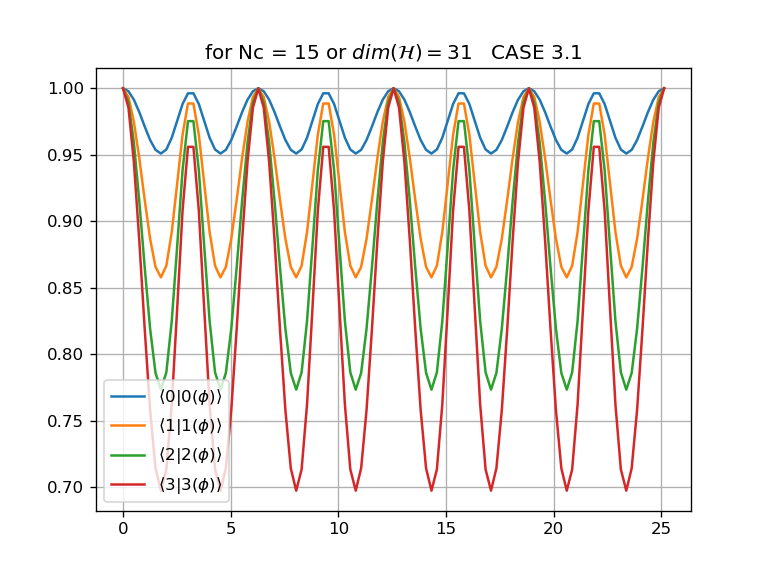

In [9]:
pars_list = []
for phi_Ext in phi_Ext_list:
    phi_Ext1 = phi_Ext
    phi_Ext2 = 0
    pars_list.append(
        TmonPars(Ec, Ej, alpha, phi_Ext1, phi_Ext2, gamma_rel, gamma_phi)
    )
tr31 = Transmon(pars_list, Nc=Nc, res_trunc=4)
sols31 = tr31.solve()
res_list3 = np.array([sol.evecs_arr for sol in sols31])
n_entries = len(res_list3)
fig, ax = plt.subplots(1,1)
goodness3 = np.zeros(res_list3.shape, dtype=complex)

for i in range(res_list3.shape[0]):
    for j in range(res_list3.shape[1]):
        goodness3[i,j] = np.abs((res_list3[i,j].dag() * res_list3[0,j])[0,0])

for vec_idx, vec_goodness in enumerate(goodness3.T):
    ax.plot(phi_Ext_list, np.abs(vec_goodness), label=r"$\left\langle %d | %d(\phi) \right\rangle  $"%(vec_idx,vec_idx))
ax.legend()
ax.set_title(r"for Nc = 15 or $dim(\mathcal{H}) = 31 $   CASE 3.1")
ax.grid()

  0%|          | 0/101 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


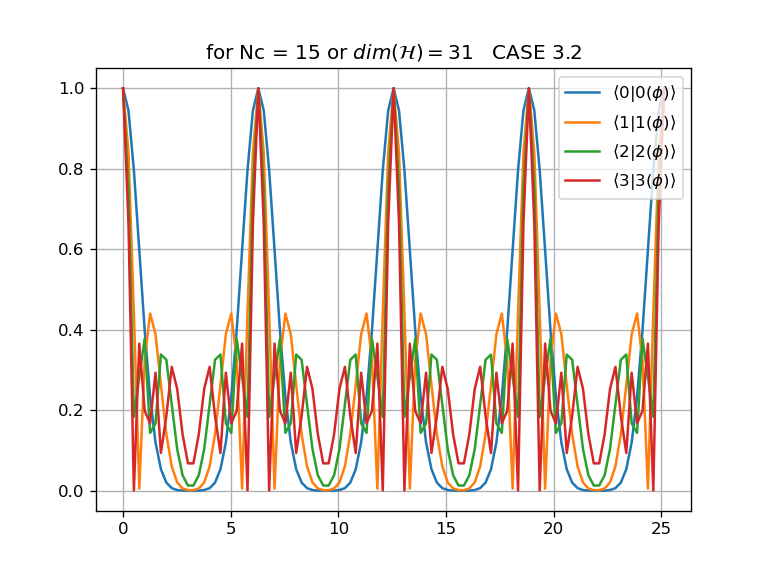

In [10]:
pars_list = []
for phi_Ext in phi_Ext_list:
    phi_Ext1 = 0
    phi_Ext2 = phi_Ext
    pars_list.append(
        TmonPars(Ec, Ej, alpha, phi_Ext1, phi_Ext2, gamma_rel, gamma_phi)
    )
tr32 = Transmon(pars_list, Nc=Nc, res_trunc=4)
sols32 = tr32.solve()
res_list3 = np.array([sol.evecs_arr for sol in sols32])
n_entries = len(res_list3)
fig, ax = plt.subplots(1,1)
goodness3 = np.zeros(res_list3.shape, dtype=complex)

for i in range(res_list3.shape[0]):
    for j in range(res_list3.shape[1]):
        goodness3[i,j] = np.abs((res_list3[i,j].dag() * res_list3[0,j])[0,0])

for vec_idx, vec_goodness in enumerate(goodness3.T):
    ax.plot(phi_Ext_list, np.abs(vec_goodness), label=r"$\left\langle %d | %d(\phi) \right\rangle  $"%(vec_idx,vec_idx))
ax.legend()
ax.set_title(r"for Nc = 15 or $dim(\mathcal{H}) = 31 $   CASE 3.2")
ax.grid()

Next calculations are based on parameters of the real design
$$ C_{sh} \approx 130 \; \text{fF} $$
$$ C_{J1} \approx 0.5  \; \text{fF} \ll C_{sh} $$
$$ C_{J2} \approx \alpha C_{J1} \ll C_{sh} $$

%%latex
yet this guess is barely close to reality due to the fact that we have distributed capacitance. 
Distributed capacitance case is examined in 
\cite{Riwar2021}

### Phi_1 = Phi_2

  0%|          | 0/101 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


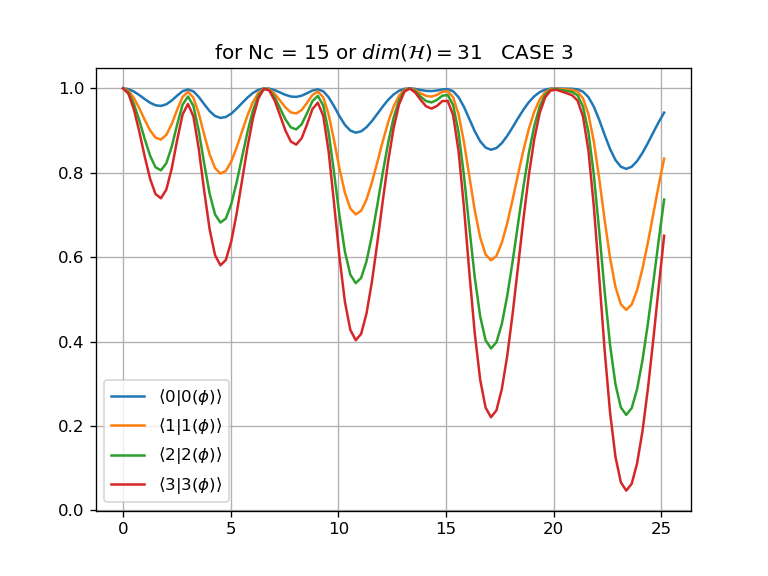

In [11]:
Csh = 130e-15
CJ1 = 0.5e-15
CJ2 = CJ1* alpha
Csigma = Csh + CJ1 + CJ2
pars_list = []
for phi_Ext in phi_Ext_list:
    phi_Ext1 = phi_Ext
    phi_Ext2 = phi_Ext
    # `mul` part is based on equation (2) from http://arxiv.org/abs/2103.03577
    phi_Ext1 = (Csh/Csigma*phi_Ext1 - CJ2/Csigma*phi_Ext2)
    phi_Ext2 = (Csh/Csigma*phi_Ext1 - (CJ1 + Csh)/Csigma*phi_Ext2)
    pars_list.append(
        TmonPars(Ec, Ej, alpha, phi_Ext1, phi_Ext2, gamma_rel, gamma_phi)
    )
tr3 = Transmon(pars_list, Nc=Nc, res_trunc=4)
sols3 = tr3.solve()
res_list3 = np.array([sol.evecs_arr for sol in sols3])
n_entries = len(res_list3)
fig, ax = plt.subplots(1,1)
goodness3 = np.zeros(res_list3.shape, dtype=complex)

for i in range(res_list3.shape[0]):
    for j in range(res_list3.shape[1]):
        goodness3[i,j] = np.abs((res_list3[i,j].dag() * res_list3[0,j])[0,0])

for vec_idx, vec_goodness in enumerate(goodness3.T):
    ax.plot(phi_Ext_list, np.abs(vec_goodness), label=r"$\left\langle %d | %d(\phi) \right\rangle  $"%(vec_idx,vec_idx))
ax.legend()
ax.set_title(r"for Nc = 15 or $dim(\mathcal{H}) = 31 $   CASE 3")
ax.grid()

### Summary

solutions

Case I

In [12]:
phi_Ext_list = np.linspace(0, 8*np.pi, 401)
pars_list = [TmonPars(Ec, Ej, alpha, phi, 0, gamma_rel, gamma_phi) for phi in phi_Ext_list]
tr1 = Transmon(pars_list, Nc=Nc, res_trunc=4)
sols1 = tr1.solve()

  0%|          | 0/401 [00:00<?, ?it/s]

Case II

In [13]:
pars_list = [TmonPars(Ec, Ej, alpha, 0, phi, gamma_rel, gamma_phi) for phi in phi_Ext_list]
tr2 = Transmon(pars_list, Nc=Nc, res_trunc=4)
sols2 = tr2.solve()

  0%|          | 0/401 [00:00<?, ?it/s]

Case III

In [14]:
Csh = 130e-15
CJ1 = 0.5e-15
CJ2 = CJ1* alpha
Csigma = Csh + CJ1 + CJ2
pars_list = []
for phi_Ext in phi_Ext_list:
    phi_Ext1 = phi_Ext
    phi_Ext2 = phi_Ext
    # `mul` part is based on equation (2) from http://arxiv.org/abs/2103.03577
    phi_Ext1 = (Csh/Csigma*phi_Ext1 - CJ2/Csigma*phi_Ext2)
    phi_Ext2 = (Csh/Csigma*phi_Ext1 - (CJ1 + Csh)/Csigma*phi_Ext2)
    pars_list.append(
        TmonPars(Ec, Ej, alpha, phi_Ext1, phi_Ext2, gamma_rel, gamma_phi)
    )
tr3 = Transmon(pars_list, Nc=Nc, res_trunc=4)
sols3 = tr3.solve()

  0%|          | 0/401 [00:00<?, ?it/s]

plotting

<IPython.core.display.Javascript object>


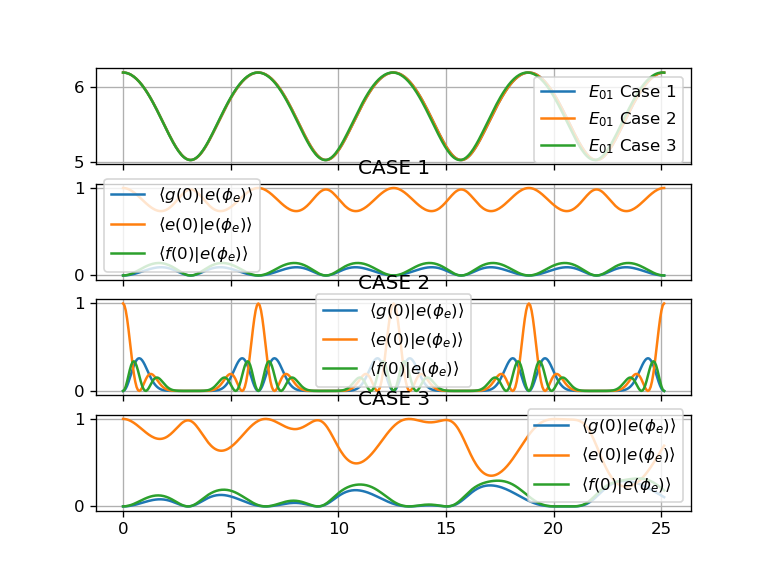

In [15]:
fig, axs = plt.subplots(4,1, sharex=True)
for sols_idx, sols in enumerate([sols1, sols2, sols3]):
    axs[0].plot(phi_Ext_list, [sol.E01() for sol in sols], label=r"$E_{01}$ Case " + str(sols_idx+1) )
    eg_overlap = [sols[0].g_state().overlap(sol.e_state()) for sol in sols]
    ee_overlap = [sols[0].e_state().overlap(sol.e_state()) for sol in sols]
    fe_overlap = [sols[0].f_state().overlap(sol.e_state()) for sol in sols]
    axs[sols_idx+1].plot(phi_Ext_list, np.abs(eg_overlap)**2, label=r"$\left< g(0) \vert e(\phi_{e}) \right>$")
    axs[sols_idx+1].plot(phi_Ext_list, np.abs(ee_overlap)**2, label=r"$\left< e(0) \vert e(\phi_{e}) \right>$")
    axs[sols_idx+1].plot(phi_Ext_list, np.abs(fe_overlap)**2, label=r"$\left< f(0) \vert e(\phi_{e}) \right>$")
for ax_idx, ax in enumerate(axs):
    ax.legend()
    ax.grid()
    if ax_idx > 0:
        ax.set_title("CASE " + str(ax_idx))

Case I:
$$ H_J = -E_J sign\left( cos{\left( \frac{\phi_{ext}}{2}\right)} \right)
\sqrt{1 + \alpha^2 + 2 \alpha \cos{\left( \frac{\phi_{ext}}{2} \right)}} \cos{\phi} $$
where 
$$\phi = \frac{\phi_1 + \phi_2}{2} $$
$\phi_i$ - phase drop accross i-th JJ
where $\phi$ - is qubit branch flux canonical variable<br>
$\alpha = E_{J1}/E_{J2} < 1$ is the ratio between smaller JJ energy to larger.

Case II: 
$$H_J =  -E_J sgn({cos{\left( \frac{\phi_{ext}}{2} \right)}}) \sqrt{1 + \alpha^2 + 2 \alpha \cos{\left( \frac{\phi_{ext}}{2} \right)}} \cos{\left( \phi - \phi_0 \right) } $$
where $\phi_0 = \arctan{\left( d \tan{\left( \frac{\phi_{ext}}{2} \right)} \right)} $ and $d = \frac{1-\alpha}{1+\alpha}$

Case III:
$$ H_J = -E_{J1}\cos{\left( \tilde{\phi} -\frac{C_{sh}}{C_{\Sigma}}\phi_0 + \frac{C_{J2}}{C_{\Sigma}}\phi_0 \right)} 
- \alpha E_J \cos{\left(\tilde{\phi}  -\frac{C_{sh}}{C_{\Sigma}}\phi_0 -\frac{C_{sh} + C_{J1}}{C_{\Sigma}}\phi_0 \right)} $$ <br>
in case with <br>
$C_{sh} = 130 \times 10^{-15}$ F <br>
$C_{J1} = 0.5 \times 10^{-15}$ F <br>
$C_{J2} = \alpha C_{J1}$ F

# Berry curvature

## Analytic expression

For eigenstate with index $n$ there is a quantity called Berry's phase (Berry himself called it "geometrical phase") that has following definition:
$$ \gamma_n(P_{a,b}) = i \int\limits_{P_{a,b}}  \left< n(\vec{\textbf{R}}) \left| \nabla_{\vec{{\textbf{R}}}} \right| n(\vec{\textbf{R}})\right>$$
Integral along path $P_{a,b}$ that connects points $a$ and $b$ in Hamiltonian parameter space.
Parameters are changed adiabatically, such that
$$ \left| \partial_t \vec{\textbf{R}}\right| \ll \frac{h}{E_1 - E_2} $$
where $E_1$ and $E_2$ are energies of the levels related to problem. Also $\vec{\textbf{R}}$ chosen dimensionless.

Related quantity called Berry curvature is a (0,2) tensor in parameters space:
$$ \Omega_{n,\mu \nu}(\vec{\textbf{R}}) = \partial_{\mu} A_{n,\nu}(\vec{\textbf{R}}) - \partial_{\nu} A_{n,\mu}(\vec{\textbf{R}}) $$
where

$$\vec{\textbf{A}}_{n,\mu}
(\vec{\textbf{R}}) = \left< n(\vec{\textbf{R}}) \left| \nabla_{\mu} \right| n(\vec{\textbf{R}})\right> $$

called a Berry's path.

The idea is that Berry's curvature is U(1) invariant while Berry's path is not.
Hence, explicitly U(1) invariant expression for Berry's phase (using Stoke's theorem) for path that is simple cycle:
$$ \gamma_n(C) = \int\limits_{\partial S = C} d\textbf{S} \; \mathbf{\Omega}_{n} $$

From derivation of a Berry's path it can be shown that (utilizing second order perturbation theory to calculate derivatives at given parameter-space point):
$$ \Omega_{n,\mu,nu}(R) = i \sum_{n'
\neq n}\frac{
\langle n|\partial H / \partial R_{\mu}|n'\rangle \langle n'|\partial H / \partial R_{\nu} | n\rangle  - 
\langle n|\partial H / \partial R_{\nu}|n'\rangle \langle n'|\partial H / \partial R_{\mu} | n\rangle
}
{(E_n - E_{n'})^2}
$$

## Definition of the parameter space

Three parameters of Hamiltonian are chosen:<br>
$\Omega \in [0, \infty]$ - external drive amplitude <br>
$\varphi_d \in [0,2\pi)$ - external drive phase <br>
$\phi_{ext} \in \mathds{R}$ - external flux value

Hamiltonian can be written as:
$$ H/h = E_C n^2 - E_{J1}\cos{(\phi - \alpha_1 \phi_{ext})} - E_{J2}\cos{(\phi - \alpha_2 \phi_{ext})} + n g \Omega \cos{(\omega_d t + \varphi_d)}$$
where 
$\alpha_1, \alpha_2 \in \mathds{R}$ - arbitrary real numbers
Columb calibration assumed to be utilized for Hamiltonian quantization for qubit with distributed capacitor geometry. This choice is dictated from \cite{Riwar2021}

## Problem for test

%%latex
We will consider adiabatic evolution of non-relaxating qubit in parameter space. Evolution will be calculated along closed 3D trajectory.
Dynamics will be obtained from direct numerical solution of the Shrodingher equation.
Then we obtain Berry phase via 2 means:
1. From numerical solution Berry phase will be extracted by substracting dynamical phase that will also be calculated numerically.
2. Direct calculation of path (calculated numerically, derivative will be approximated by finite difference scheme)
3. Area integral of Berry's curvature (curvature will be calculated exactly with formula above)

trajectory is an ellips in 3d that touches coordinate origin.

$$x = A_x \cos{\alpha}(1+\cos{(\omega t}))$$
$$y = A_y \sin{(\omega t)}$$
$$z = A_x \sin{\alpha}(1+\cos{(\omega t)})$$

### trajectory parameters and speed definition

In [31]:
tr = Transmon([TmonPars(Ec, Ej, alpha, 0,0,0,0)], Nc=Nc)
sols = tr.solve(progress=False)
omega_d = sols[0].evals_arr[1]
anh = np.abs(sols[0].anharmonicity())

Ax = 20e-3*anh
Ay = 10e-2*anh
v_adiab = 0.0001*1/anh
omega_tr = v_adiab*2*np.pi  # trajectory omega
angle = 0  # np.pi/6  # 30 degree
alpha1 = 0.3
alpha2 = 0.7

tlist = np.linspace(0, 2*np.pi/omega_tr, 1001, endpoint=False)

  0%|          | 0/1 [00:00<?, ?it/s]

### 3D plot of trajectory in (x,y,z)

<IPython.core.display.Javascript object>


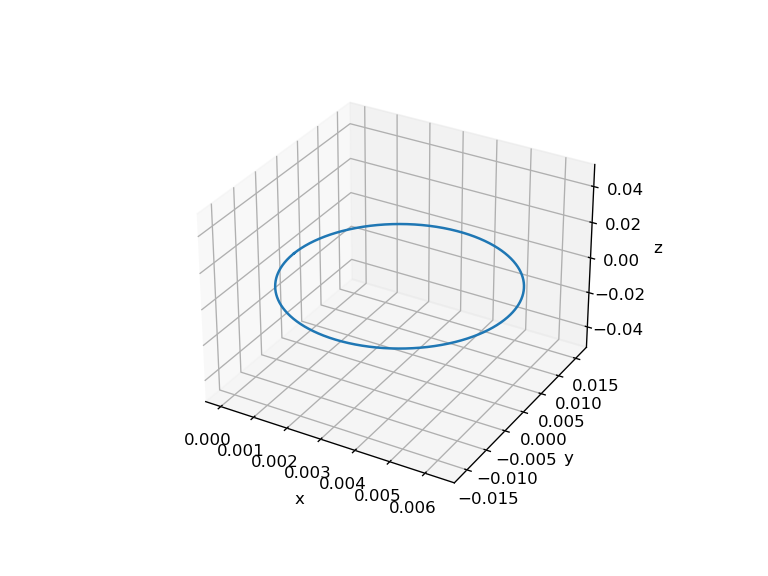

Text(0.5, 0, 'z')

In [32]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(
    Ax*np.cos(angle)*(1-np.cos(omega_tr*tlist)), 
    Ay*np.sin(omega_tr*tlist), 
    Ax*np.sin(angle)*(1-np.cos(omega_tr*tlist))
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

In [33]:
def phi_ext_t(t):  # z
    return Ax*np.sin(angle)*(1-np.cos(omega_tr*t))

def phase(t):  # \phi
    return np.arctan2(
        Ay*np.sin(omega_tr*t),
        Ax*np.cos(angle)*(1-np.cos(omega_tr*t))
    )  # arctan2(y,x)

def Omega(t):  # sqrt(x^2 + y^2)
    return np.sqrt((Ax*np.cos(angle)*(1-np.cos(omega_tr*t)))**2 + (Ay*np.sin(omega_tr*t))**2)

### 3D plot of trajectory in (Omega, phi, z)

<IPython.core.display.Javascript object>


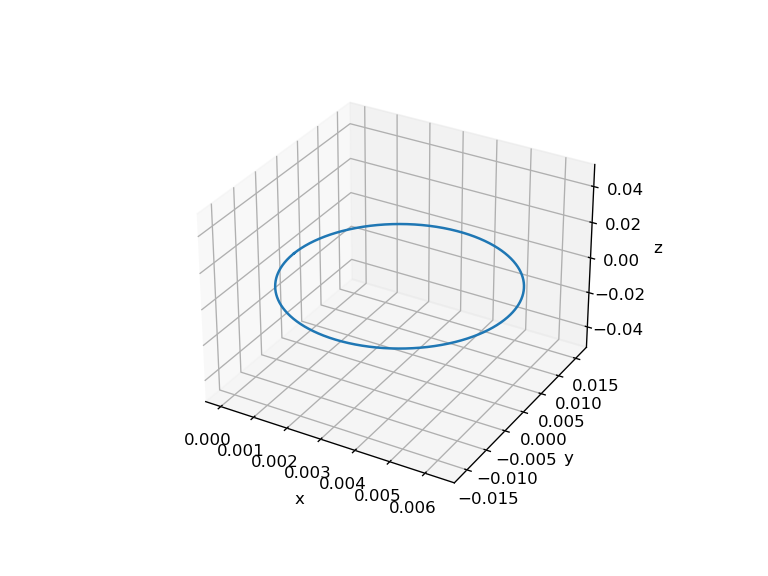

Text(0.5, 0, 'z')

In [34]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
phase_l = phase(tlist)
Omega_l = Omega(tlist)
phi_ext_l = phi_ext_t(tlist)
ax.plot(Omega_l*np.cos(phase_l), Omega_l*np.sin(phase_l), phi_ext_l)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

### DIRECT Adiabatic trajectory calculation (`Transmon` class)

Adiabatic solution is generated as a sequence of $|e(\vec{\mathbf{R}})\rangle$ eigenstates without any approximations.

In [35]:
phi_ext_l = phi_ext_l
Amp_d_l = Omega_l
phase_l = phase_l
pars_list = [
    TmonPars(
        Ec, Ej, alpha, alpha1*phi_ext, alpha2*phi_ext,
        gamma_rel, gamma_phi,
        Amp_d, omega_d, phase_d, t
    ) for phi_ext, Amp_d, phase_d, t in zip(phi_ext_l, Amp_d_l, phase_l, tlist)]
tr = Transmon(pars_list, Nc=Nc, res_trunc=3, index=None)

In [36]:
T = 2*np.pi/omega_tr
T

1589.4810138568262

In [22]:
resolution_t = T/len(tlist)
1/resolution_t  # GHz

0.6297653078416487

intensive calculations

In [23]:
sols = tr.solve()

  0%|          | 0/1001 [00:00<?, ?it/s]

### Direct numerical solution (does not have adiabatic properties for computationally available dR/dt -> 0)

initial state is $|e(\phi_{ext}=\Omega=0)\rangle$

In [24]:
psi0 = sols[0].e_state()
psi0

Quantum object: dims = [[21], [1]], shape = (21, 1), type = ket
Qobj data =
[[-2.68386339e-04]
 [ 1.34619774e-03]
 [-5.57050904e-03]
 [ 1.94328085e-02]
 [-5.65069480e-02]
 [ 1.34841380e-01]
 [-2.58661007e-01]
 [ 3.86592088e-01]
 [-4.24020086e-01]
 [ 2.86465051e-01]
 [ 0.00000000e+00]
 [-2.86465051e-01]
 [ 4.24020086e-01]
 [-3.86592088e-01]
 [ 2.58661007e-01]
 [-1.34841380e-01]
 [ 5.65069480e-02]
 [-1.94328085e-02]
 [ 5.57050904e-03]
 [-1.34619774e-03]
 [ 2.68386339e-04]]

anharmonicity

In [25]:
def fr_t(t, args_dict):
    alpha1 = args_dict["alpha1"]
    alpha2 = args_dict["alpha2"]
    phi_ext = phi_ext_t(t)
    return 1/2*np.exp(-1j*alpha1*phi_ext)+alpha*np.exp(-1j*alpha2*phi_ext)

def fl_t(t, args_dict):
    alpha1 = args_dict["alpha1"]
    alpha2 = args_dict["alpha2"]
    phi_ext = phi_ext_t(t)
    return 1/2*np.exp(1j*alpha1*phi_ext)+alpha*np.exp(1j*alpha2*phi_ext)

def fc_t(t, args_dict):
    return -Omega(t)*np.cos(omega_d*t + phase(t))

n = qp.charge(Nc)
Hc = Ec*(n**2)
H = [
    Hc,
    [n, fc_t],
    [-Ej*raising_op(dims), fr_t],
    [-Ej*lowering_op(dims), fl_t]
]

evolution period

In [27]:
T = 2*np.pi/omega_tr
T  # ns

1589.4810138568262

In [28]:
args_dict = {
    "alpha1": alpha1,
    "alpha2": alpha2
}
try:
   res = qp.sesolve(H, psi0, tlist, args=args_dict, progress_bar=True)
except Exception as e:
    print(e)

10.1%. Run time:   4.06s. Est. time left: 00:00:00:36
20.1%. Run time:   7.89s. Est. time left: 00:00:00:31
30.1%. Run time:  11.67s. Est. time left: 00:00:00:27
40.1%. Run time:  15.46s. Est. time left: 00:00:00:23
50.0%. Run time:  19.24s. Est. time left: 00:00:00:19
60.0%. Run time:  23.11s. Est. time left: 00:00:00:15
70.0%. Run time:  26.88s. Est. time left: 00:00:00:11
80.0%. Run time:  30.64s. Est. time left: 00:00:00:07
90.0%. Run time:  34.51s. Est. time left: 00:00:00:03
Total run time:  38.24s


<IPython.core.display.Javascript object>


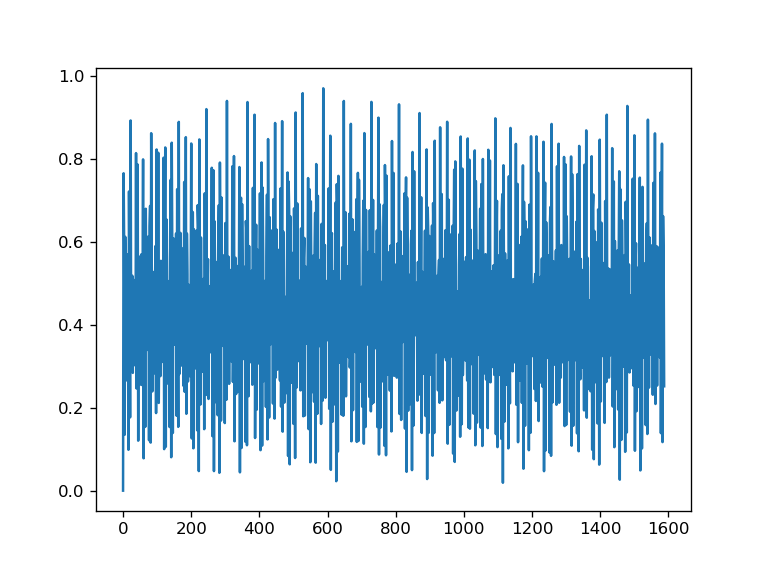

In [29]:
evecs = [sol.e_state() for sol in sols]
overlap = np.array([np.abs(evec.overlap(evol_vec)) for evec, evol_vec in zip(evecs, res.states)])
fig, ax = plt.subplots(1,1)
error = 1 - overlap
ax.plot(tlist, error)

<IPython.core.display.Javascript object>


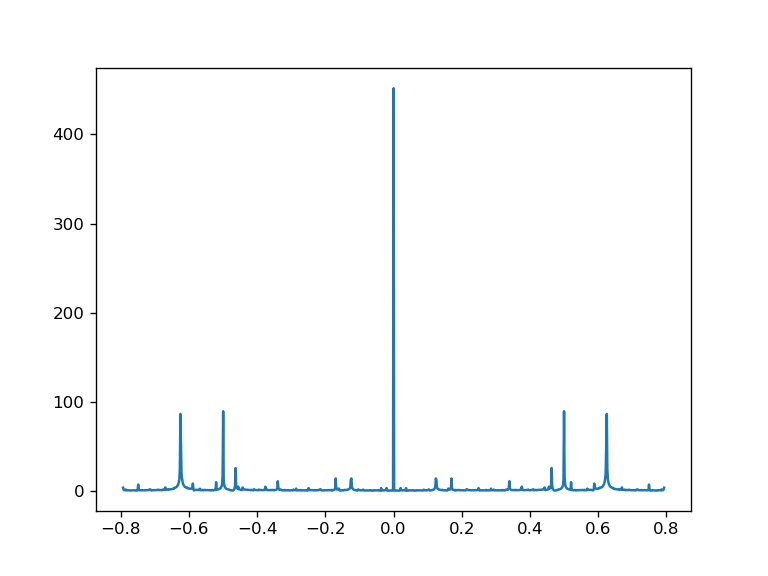

In [30]:
fig, ax = plt.subplots(1,1)
error_fft = np.fft.fftshift(np.fft.fft(error))
freqs = np.fft.fftshift(np.fft.fftfreq(len(error_fft), d=1/(tlist[1]-tlist[0])))
ax.plot(freqs, np.abs(error_fft))

### RWA numerical solution

$$ H/\hbar = E_C n^2 - E_{J1}\cos{(\phi - \alpha_1 \phi_{ext})} - E_{J2}\cos{(\phi - \alpha_2 \phi_{ext})} + n g \Omega \cos{(\omega_d t + \varphi_d)}$$
$$ H_0 = diag(0, -\omega_d, -2\omega_d, ...,  -n\omega_d) $$

operator $\hat{n}$ in eigenbasis:
$$\hat{n} = 
\left(
\begin{matrix}
0 & n_{01} & 0 & n_{03} & \dots \\
n_{01} & 0 & n_{12} & 0 & \dots \\
0 & n_{12} & 0 & n_{23} & \dots \\
n_{03} & 0 & n_{23} & 0 & \dots \\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{matrix}\right)
$$

$$ \hat{n} = \sum_{k=1,3,\dots}^{\infty} (n_{+k} + n_{-k}) $$

where $n_{m}$ - matrix that has only nonzero entries on $m^{\text{th}}$ diagonal. These entries correspond to $\hat{n}$ operator<br>
$m = 0$ - corresponds to main diagonal <br>
$ m = 1 $ - corresponds to first upper diagonal <br>
$ m = -1 $ corresponds to first lower diagonal <br>

after transformation into interaction pictrure with $H_0$ above:
$$e^{i H_0 t} \hat{n} e^{- i H_0 t} = 
\left(
\begin{matrix}
0 & n_{01}e^{i \omega_d t} & 0 & n_{03}e^{3 i \omega_d t} & \dots \\
n_{01}e^{-i \omega_d t} & 0 & n_{12}e^{i \omega_d t} & 0 & \dots \\
0 & n_{12}e^{-i \omega_d t} & 0 & n_{23}e^{i \omega_d t} & \dots \\
n_{03}e^{-3 i \omega_d t} & 0 & n_{23}e^{-i \omega_d t} & 0 & \dots \\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{matrix}
\right)
$$

In [ ]:
sols[0].n_op

so 
$$e^{i H_0 t} \hat{n} e^{- i H_0 t} = \sum_{k=1,3,\dots}^{\infty} (n_{+k}e^{-i k \omega_d t} + n_{-k}e^{i k \omega_d t}) $$

In [ ]:
def fr_t(t, args_dict):
    alpha1 = args_dict["alpha1"]
    alpha2 = args_dict["alpha2"]
    phi_ext = phi_ext_t(t)
    return np.exp(-1j*alpha1*phi_ext)+alpha*np.exp(-1j*alpha2*phi_ext)

def fl_t(t, args_dict):
    alpha1 = args_dict["alpha1"]
    alpha2 = args_dict["alpha2"]
    phi_ext = phi_ext_t(t)
    return np.exp(1j*alpha1*phi_ext)+alpha*np.exp(1j*alpha2*phi_ext)

def fc_t(t, args_dict):
    return Omega(t)*np.cos(omega_d*t + phase(t))

n = qp.charge(Nc)
Hc = Ec*n**2
H = [
    Hc,
    [n, fc_t],
    [-Ej*raising_op(dims), fr_t],
    [-Ej*lowering_op(dims), fl_t]
]

initial state is $|e(\phi_{ext}=\Omega=0)\rangle$

# Sandbox

In [ ]:
tr = 

In [ ]:
sols1[0].e_state()

In [ ]:
args_dict = {
    "pulse_omega": 2e-3,  # GHz
    "phase_amp": np.pi/4,
    "alpha": alpha,
    "Ej": Ej
}
sesolve_res = qp.sesolve(H_list_callback, sols1[0].e_state(), tlist, args=args_dict, progress_bar=True)

In [ ]:
sesolve_res.states[1]

In [ ]:
b3d = qp.Bloch3d()

In [ ]:
for mul in np.linspace(-1,2, 4):
    # phi_ext pulse shape
    for phi_ext in phi_ext_list:
        pars = TmonPars(
            Ec=0.6, Ej=28, alpha=0.2,
            phiExt1=mul*phi_ext, phiExt2=(mul - 1)*phi_ext,
            gamma_rel=0.1e-3,  # GHz
            gamma_phi=0.5e-3,  # GHz
        )
        pars_list.append(pars)
    tr = Transmon(pars=pars_list, Nc=Nc, res_trunc=res_trunc)

In [ ]:
from transmon_simulations_lib.custom_ops import raising_op, lowering_op

# Z-gate

In [ ]:
import transmon_simulations_lib.single_transmon.transmon
reload(transmon_simulations_lib.single_transmon.transmon)
from transmon_simulations_lib.single_transmon.transmon import Transmon

In [ ]:
import scipy.signal
def gauss(t, t0, gdt):
    import scipy.stats
    gauss_hat_centered = scipy.stats.norm(t0, gdt).pdf(t)
    return gauss_hat_centered

def phi(t, start, tau, gdt):
    phi = np.zeros(t.shape)
    phi[((t > start) & (t < start + tau))] = 1
    if gdt != 0:
        phi = scipy.signal.convolve(phi,gauss(t, t[-1]/2, gdt),mode='same')
    return phi

In [ ]:
fix, ax = plt.subplots(1,1)
pdata = gauss(Ts,Ts[-1]/2, 2)
ax.plot(pdata)
scipy.integrate.quad(lambda x: gauss(x,Ts[-1]/2,2), Ts[-1]/2 - 4, Ts[-1]/2 + 4)

pulse preparation

In [ ]:

tau = 100  # Gate length
dgt = 12   # typical rise-fall time of the pulse
t_rise = 3*dgt  # several rise-fall times to ensure most pulse is in window
t_start = t_rise  # severak rise-fall times
Ts = np.linspace(0,t_rise + tau + t_rise,1001)
phi_list = phi(Ts, t_start, tau, dgt)
phi_list *= np.pi/16/np.max(phi_list)
fig, ax = plt.subplots(1,1, figsize=(4,3))
ax.plot(Ts, phi_list)
ax.set_xlabel("ns")
ax.set_ylabel("rad")
fig.tight_layout()

### Case I

In [ ]:
tr = Transmon(Ec1, Ej1, alpha=alpha, phi=0, Nc=10)
first_evecs_N = 5
first_evecs = tr.solve()[0].evecs[:first_evecs_N]
H_list = [tr.calc_Hfull_cb(phi) for phi in phi_list]
def H_callback(t, *args):
    i = np.argmin(np.abs(t-Ts))
    return H_list[i]
def H_0_callback(t, *args):
    return H_list[0]
sol = qp.sesolve(H_callback, psi1, Ts, options=qp.Options(nsteps=10000))

In [ ]:
fig, ax = plt.subplots(1,1)

projs = []
for evec in first_evecs:
    bra_vec = evec.dag()
    projs.append(np.array([(bra_vec*state_ket)[0,0] for state_ket in sol.states]))
projs = np.array(projs)

for i, proj in enumerate(projs):
    label_str = r"$P_{1 \rightarrow " + f"{i}" + r" }$"
    ax.plot(Ts, np.abs(proj)**2, label=label_str)
s = np.sum(np.abs(projs)**2, axis=0)
ax.plot(Ts, s, label="total population of first \n" + str(len(projs)) + r" eigenstates in $\phi_{ext} = 0$ basis")
ax.legend()
ax.set_xlabel("ns")
ax.set_ylim(-0.05, 1.05)

### Case II

In [ ]:
tr = Transmon(Ec1, Ej1, alpha=alpha, phi=0, Nc=10)
first_evecs_N = 5
first_evecs = tr.solve()[0].evecs[:first_evecs_N]
H_list = [tr.calc_Hfull_cb2(phi) for phi in phi_list]
def H_callback(t, *args):
    i = np.argmin(np.abs(t-Ts))
    return H_list[i]
def H_0_callback(t, *args):
    return H_list[0]
sol = qp.sesolve(H_callback, psi1, Ts, options=qp.Options(nsteps=10000))

In [ ]:
fig, ax = plt.subplots(1,1)

projs = []
for evec in first_evecs:
    bra_vec = evec.dag()
    projs.append(np.array([(bra_vec*state_ket)[0,0] for state_ket in sol.states]))
projs = np.array(projs)

for i, proj in enumerate(projs):
    label_str = r"$P_{1 \rightarrow " + f"{i}" + r" }$"
    ax.plot(Ts, np.abs(proj)**2, label=label_str)
s = np.sum(np.abs(projs)**2, axis=0)
ax.plot(Ts, s, label="total population of first \n" + str(len(projs)) + r" eigenstates in $\phi_{ext} = 0$ basis")
ax.legend()
ax.set_xlabel("ns")
ax.set_ylim(-0.05, 1.05)

# Not sorted

In [ ]:
# qubit 1 jumps from phi = 0 to phi = pi/2 and back
# qubit 2 resides in phi = pi/2
phi_list_cache = np.linspace(0, np.pi/2, int(1e2))

if __name__ == '__main__':
    mp.freeze_support()
    args = []
from single_transmon.transmon import foo
def foo(args):
    return args["phi_offset"]
for phi in phi_list_cache:
    args.append({"phi_offset": phi})
with mp.Pool(mp.cpu_count()-1) as p:
    res = list(p.map(foo, tqdm.tqdm(args)))

In [ ]:
chain = TransmonChain(4, transmon_truncation = 3)
chain.set_phi((params['phi_base_level'] + params['phi_offset'],params['phi2z_base_level'],0.6,0.7))
chain._transmons = [tr1, tr2,tr3,tr4]
chain.set_J([0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5, 0.01/1.2**2 * 2 * np.pi/5])
chain.build_low_energy_kets(2,0)
chain._Ts = Ts
rho0 = [ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0))]
rho0 = tensor(*rho0)
rho0 = chain.truncate_to_low_population_subspace(rho0)
chain.rho0 = rho0
sigma_z_chain = []
sigma_x_chain = []
sigma_y_chain = []
for i in range (4): #TO DO - вынести в функцию класса
    sigma_z = chain._transmons[i].sz()
    sigma_x = chain._transmons[i].sx()
    sigma_y = chain._transmons[i].sy()
    oper_z = chain._identity_array.copy()
    oper_z[i]=sigma_z
    oper_x = chain._identity_array.copy()
    oper_x[i]=sigma_x
    oper_y = chain._identity_array.copy()
    oper_y[i]=sigma_y
    sigma_z_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_z)))
    sigma_x_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_x)))
    sigma_y_chain.append(chain.truncate_to_low_population_subspace(tensor(*oper_y)))

chain.e_ops = sigma_z_chain + sigma_x_chain + sigma_y_chain


# Свободная эволюция системы

### 1й и 2й кубит в цепочке в резонансе, изначально первый кубит возбуждён

In [ ]:
rho0 = [ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0))]
rho0[0] = ket2dm((basis(3,1) + basis(3,0))/sqrt(2)) # задаём начальное состояние 1го кубита
rho0 = tensor(*rho0)
rho0 = chain.truncate_to_low_population_subspace(rho0)
waveform1_const = ones_like(Ts)*(params['phi_base_level']+params['phi_offset'])
waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform3_const = ones_like(Ts)*0.6
waveform4_const = ones_like(Ts)*0.7


H_full_test = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[0,0],[0,0],[0,0],[0,0]] )

result = mesolve(H_full_test, rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

In [ ]:
chain.plot_chain_dynamic(result)

## Эволюция под действием внешнего поля

### Кубиты не в резонансе, поле действует на первый и третий кубиты

In [ ]:
chain.set_phi((params['phi_base_level'],params['phi2z_base_level'],0.6,0.7))

In [ ]:
waveform1_const = ones_like(Ts)*(params['phi_base_level'])
waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform3_const = ones_like(Ts)*0.6
waveform4_const = ones_like(Ts)*0.7

In [ ]:
H_full = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[T._pi_duration,0],[0,0],[T._pi_duration/2,0],[0,0]] )

result = mesolve(H_full, chain.rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

chain.plot_chain_dynamic(result)

### 1й, 2й и 3й кубиты в резонансе, поле действует на первый

In [ ]:
waveform1_const = ones_like(Ts)*(params['phi_base_level'] + params['phi_offset'] )
waveform2_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform3_const = ones_like(Ts)*(params['phi2z_base_level'])
waveform4_const = ones_like(Ts)*0.7
chain.set_phi((params['phi_base_level'] + params['phi_offset'],params['phi2z_base_level'],params['phi2z_base_level'],0.7))

H_full = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[T._pi_duration,0],[0,0],[0,0],[0,0]] )

result = mesolve(H_full, chain.rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

chain.plot_chain_dynamic(result)

## Vacuum rabi oscillations

Приготавливаем первый кубит в возбуждённом состоянии, затем на какое-то время перестраиваем его по потоку. При попадании в резонанс со вторым кубитом наблюдаются осцилляции заселённости возбуждённого состояния 1-го и 2-го кубитов. Можно построить зависимость заселённости второго кубита от отстройки по потоку и времени взаимодействия. 

In [ ]:
signal = ZPulse(Ts,params)
chain.set_phi((params['phi_base_level'],params['phi2z_base_level'],0.6,0.7))



## Форма потокового импульса, подающегося на первый кубит (для одного значения параметров)

In [ ]:
figure()
plot(Ts, vacuum_rabi_waveform(200, 0.03, Ts, params)[0])

In [ ]:
##special for windows 
durations = linspace (50, 250, 50)
phis = linspace (0.025, 0.035, 200)
size = len(phis)
args = []
for ind, phi in enumerate (phis):
    dict_arg = {'chain' : chain, 'params' : params, 'durations' : durations, 'phi_offset' : phi}
    args.append(dict_arg)
    
if __name__=='__main__':
    with Pool(4) as p:
        populations = p.map(vacuum_rabi_populations_one_phi_windows, tqdm(args))

In [ ]:
figure()
pcolormesh(durations, phis, populations)
colorbar()
#savefig('01.12.2021_vacuum_rabi_4q.png')

## Iswap Gate

Пример эволюции кубитов при проведении гейта i-swap, первый кубит изначально переводится в состояние на экваторе сферы блоха, 
далее первый и второй кубиты переводятся в резонанс, после этого проводится фазовая коррекция с помощью Z-гейта.  

In [ ]:
rho0 = [ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0)),ket2dm(basis(3,0))]
rho0 = tensor(*rho0)
rho0 = chain.truncate_to_low_population_subspace(rho0)
chain.set_phi((params['phi_base_level'],params['phi2z_base_level'],0.6,0.7))
chain.set_J([0.01/1.2**2 * 2 * np.pi/5, 0,0,0])
signal = ZPulse(Ts,params)
waveform1 = signal.waveform_iswap_zgate(1)
waveform2 = signal.waveform_iswap_zgate(2)
waveform3_const = ones_like(Ts)*0.6
waveform4_const = ones_like(Ts)*0.7
H_full = chain.build_H_full([waveform1, waveform2, waveform3_const, waveform4_const], 
                                 params, [[T._pi_duration/2,0],[0,0],[0,0],[0,0]] )

result = mesolve(H_full, chain.rho0, Ts, 
                 c_ops = [],e_ops = chain.e_ops,
                 progress_bar=True,options=Options(nsteps = 20000, store_states = True, max_step = 1e-1))

chain.plot_chain_dynamic(result)

## Спектр системы в зависимости от потока через первый кубит

In [ ]:
levels = []

phis = linspace(0, 1, 3000)
for phi in tqdm(phis):
    phi_arr = [0.25, .5 , .6, .7]
    phi_arr[0] = phi
    chain.set_phi(phi_arr)
    waveform1_const = ones_like(Ts)*phi_arr[0]
    waveform2_const = ones_like(Ts)*phi_arr[1]
    waveform3_const = ones_like(Ts)*phi_arr[2]
    waveform4_const = ones_like(Ts)*phi_arr[3]
    H_full = chain.build_H_full([waveform1_const, waveform2_const, waveform3_const, waveform4_const], 
                                 params, [[0,0],[0,0],[0,0],[0,0]])
    H_const = chain.truncate_to_low_population_subspace(chain._zero_op)
    for i in range (12):
        if (i%3 != 2):
            H_const+=H_full[i][0]*H_full[i][1][0]
    for i in range(13,19,1):
        H_const+=H_full[i][0]
    evals, evecs = H_const.eigenstates()
    levels.append((evals-evals[0])/2/pi)

In [ ]:
figure()
plot(phis, array(levels)[:, 1:6])
plot(phis, array(levels)[:, 6:21]/2, "--")